In [1]:
import warnings
warnings.filterwarnings("ignore")

# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode(connected = True)

# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# prophet by Facebook
from fbprophet import Prophet

## データセットのロード

In [2]:
path = './input/store-sales-time-series-forecasting/'
oil_data = pd.read_csv(path+'oil.csv')
train = pd.read_csv(path+'train.csv', parse_dates = True, low_memory = False, index_col = 'date')
test = pd.read_csv(path+'test.csv')
submission_sample = pd.read_csv(path+'sample_submission.csv')
holidays_data = pd.read_csv(path+'holidays_events.csv')
store_data =  pd.read_csv(path+'stores.csv')
transaction_data = pd.read_csv(path+'transactions.csv')


# time series as indexes
train.index

DatetimeIndex(['2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01',
               ...
               '2017-08-15', '2017-08-15', '2017-08-15', '2017-08-15',
               '2017-08-15', '2017-08-15', '2017-08-15', '2017-08-15',
               '2017-08-15', '2017-08-15'],
              dtype='datetime64[ns]', name='date', length=3000888, freq=None)

In [3]:
holidays_data.values

array([['2012-03-02', 'Holiday', 'Local', 'Manta', 'Fundacion de Manta',
        False],
       ['2012-04-01', 'Holiday', 'Regional', 'Cotopaxi',
        'Provincializacion de Cotopaxi', False],
       ['2012-04-12', 'Holiday', 'Local', 'Cuenca',
        'Fundacion de Cuenca', False],
       ...,
       ['2017-12-24', 'Additional', 'National', 'Ecuador', 'Navidad-1',
        False],
       ['2017-12-25', 'Holiday', 'National', 'Ecuador', 'Navidad', False],
       ['2017-12-26', 'Additional', 'National', 'Ecuador', 'Navidad+1',
        False]], dtype=object)

# EDA

## 行と列の数

In [4]:
print('Number of train samples: ', train.shape)
print('Number of test samples: ', test.shape)
print('Number of store data: ', store_data.shape)
print('Number of Holiday data: ', holidays_data.shape)
print('Number of Oil Price data: ', oil_data.shape)
print('Number of features: ', len(train.columns))
print(train.info())
print(train.columns)
print(train.head())

Number of train samples:  (3000888, 5)
Number of test samples:  (28512, 5)
Number of store data:  (54, 5)
Number of Holiday data:  (350, 6)
Number of Oil Price data:  (1218, 2)
Number of features:  5
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000888 entries, 2013-01-01 to 2017-08-15
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 137.4+ MB
None
Index(['id', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')
            id  store_nbr      family  sales  onpromotion
date                                                     
2013-01-01   0          1  AUTOMOTIVE    0.0            0
2013-01-01   1          1   BABY CARE    0.0            0
2013-01-01   2          1      BEAUTY    0.0            0
2013-01-01   3          1   BEVERAGES    0.0           

## 特徴量の説明

## Key Fields の簡単な説明
* date: 記入日
* store_nbr: 店舗番号
* sales：任意の日の回転率（ターゲット変数）
* family: 製品ファミリー
* store_type: 店舗の種類
* cluster: 店舗クラスタ
* city: 都市名
* state: ストアがある州
* onpromotion: 店舗がその日にプロモを実施しているかどうかを示す
* holiday_type & locale : その日が休日であったかどうか、休日の種類を表す
* transactions:トランザクション数
* sales：販売数量

In [5]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000888 entries, 2013-01-01 to 2017-08-15
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 137.4+ MB


id             0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

### Generate Year, Month, Day and Week of the Year Categorical fields

In [6]:
# data extraction
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear
train['WeekOfDay'] = train.index.weekday
train.head(10)

,id,store_nbr,family,sales,onpromotion,Year,Month,Day,WeekOfYear,WeekOfDay
date,,,,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0,2013,1,1,1,1
2013-01-01,1,1,BABY CARE,0.0,0,2013,1,1,1,1
2013-01-01,2,1,BEAUTY,0.0,0,2013,1,1,1,1
2013-01-01,3,1,BEVERAGES,0.0,0,2013,1,1,1,1
2013-01-01,4,1,BOOKS,0.0,0,2013,1,1,1,1
2013-01-01,5,1,BREAD/BAKERY,0.0,0,2013,1,1,1,1
2013-01-01,6,1,CELEBRATION,0.0,0,2013,1,1,1,1
2013-01-01,7,1,CLEANING,0.0,0,2013,1,1,1,1
2013-01-01,8,1,DAIRY,0.0,0,2013,1,1,1,1


In [7]:
Sales_AVG_By_Year= train.groupby("Year").agg({"sales" : "mean"}).rename(columns={'sales':'Sales_AVG_By_Year'})

In [8]:
train = pd.merge(train,Sales_AVG_By_Year,on='Year', how='outer')

In [9]:
Sales_AVG_By_Year_Month = train.groupby(["Year","Month"]).agg({"sales" : "mean"}).rename(columns={'sales':'Sales_By_Year_Month'})

In [10]:
train = pd.merge(train,Sales_AVG_By_Year_Month,on=["Year","Month"], how='outer')

In [11]:
Sales_AVG_By_Year_WeekOfDay = train.groupby(["Year","WeekOfDay"]).agg({"sales" : "mean"}).rename(columns={'sales':'Sales_Year_WeekOfDay'})

In [12]:
train = pd.merge(train,Sales_AVG_By_Year_WeekOfDay,on=['Year','WeekOfDay'], how='outer')

In [13]:
train.index

Int64Index([      0,       1,       2,       3,       4,       5,       6,
                  7,       8,       9,
            ...
            3000878, 3000879, 3000880, 3000881, 3000882, 3000883, 3000884,
            3000885, 3000886, 3000887],
           dtype='int64', length=3000888)

In [14]:
# train.head(5)
df = pd.DataFrame(index=[])
Year = train['Year']
Month = train['Month']
Day = train['Day']
df = Year
df = df.astype(str).str.cat(Month.astype(str), sep='-')
df = df.astype(str).str.cat(Day.astype(str), sep='-')
train['date'] = pd.DataFrame(df).rename(columns={"Year":"date"})['date']
train['date'] = pd.to_datetime(train['date'], format='%Y-%m-%d')
train = train.set_index('date')

In [15]:
train.head(10)

,id,store_nbr,family,sales,onpromotion,Year,Month,Day,WeekOfYear,WeekOfDay,Sales_AVG_By_Year,Sales_By_Year_Month,Sales_Year_WeekOfDay
date,,,,,,,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0,2013,1,1,1,1,216.47953,186.952405,186.236645
2013-01-01,1,1,BABY CARE,0.0,0,2013,1,1,1,1,216.47953,186.952405,186.236645
2013-01-01,2,1,BEAUTY,0.0,0,2013,1,1,1,1,216.47953,186.952405,186.236645
2013-01-01,3,1,BEVERAGES,0.0,0,2013,1,1,1,1,216.47953,186.952405,186.236645
2013-01-01,4,1,BOOKS,0.0,0,2013,1,1,1,1,216.47953,186.952405,186.236645
2013-01-01,5,1,BREAD/BAKERY,0.0,0,2013,1,1,1,1,216.47953,186.952405,186.236645
2013-01-01,6,1,CELEBRATION,0.0,0,2013,1,1,1,1,216.47953,186.952405,186.236645
2013-01-01,7,1,CLEANING,0.0,0,2013,1,1,1,1,216.47953,186.952405,186.236645
2013-01-01,8,1,DAIRY,0.0,0,2013,1,1,1,1,216.47953,186.952405,186.236645


### トレーニングデータとストアデータを統合し、拡張ビューを実現

In [16]:
train_store=train.merge(store_data, on = 'store_nbr', how='left')
train_store.head()

,id,store_nbr,family,sales,onpromotion,Year,Month,Day,WeekOfYear,WeekOfDay,Sales_AVG_By_Year,Sales_By_Year_Month,Sales_Year_WeekOfDay,city,state,type,cluster
0,0,1,AUTOMOTIVE,0.0,0,2013,1,1,1,1,216.47953,186.952405,186.236645,Quito,Pichincha,D,13
1,1,1,BABY CARE,0.0,0,2013,1,1,1,1,216.47953,186.952405,186.236645,Quito,Pichincha,D,13
2,2,1,BEAUTY,0.0,0,2013,1,1,1,1,216.47953,186.952405,186.236645,Quito,Pichincha,D,13
3,3,1,BEVERAGES,0.0,0,2013,1,1,1,1,216.47953,186.952405,186.236645,Quito,Pichincha,D,13
4,4,1,BOOKS,0.0,0,2013,1,1,1,1,216.47953,186.952405,186.236645,Quito,Pichincha,D,13


In [17]:
Sales_AVG_By_State_Year_Week = train_store.groupby(["state", "Year", "Month", "WeekOfDay"]).agg({"sales" : "mean"}).rename(columns={'sales':'Sales_By_State_Year_Mon_WD'})

In [18]:
Sales_AVG_By_State_Year_Week

Sales_By_State_Year_Mon_WD
state      Year Month WeekOfDay                            
Azuay      2013 1     0                          124.834139
                      1                          102.213913
                      2                          140.729945
                      3                          122.256212
                      4                          122.652407
...                                                     ...
Tungurahua 2017 8     2                          446.718811
                      3                          380.608811
                      4                          415.197833
                      5                          450.014356
                      6                          471.867258

[6272 rows x 1 columns]

In [19]:
train_store = pd.merge(train_store,Sales_AVG_By_State_Year_Week,on=["state","Year","Month","WeekOfDay"], how='outer')

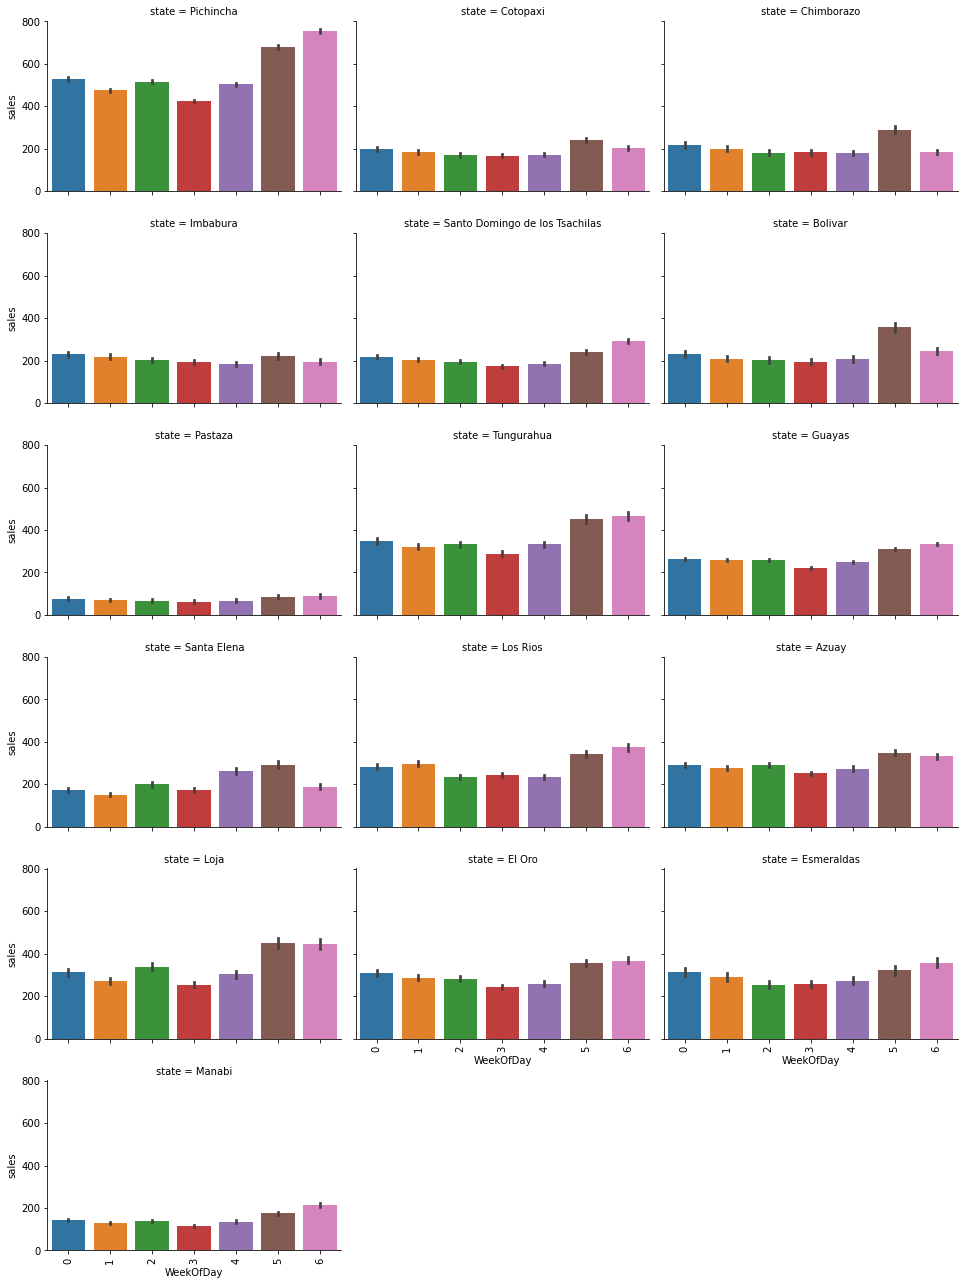

In [20]:
ax = sns.catplot(x="WeekOfDay", y="sales",kind="bar", data=train_store, 
    col='state',
    col_wrap=3, height=3, aspect=1.5, legend=True)
ax.set_xticklabels(rotation = 90)
plt.show()

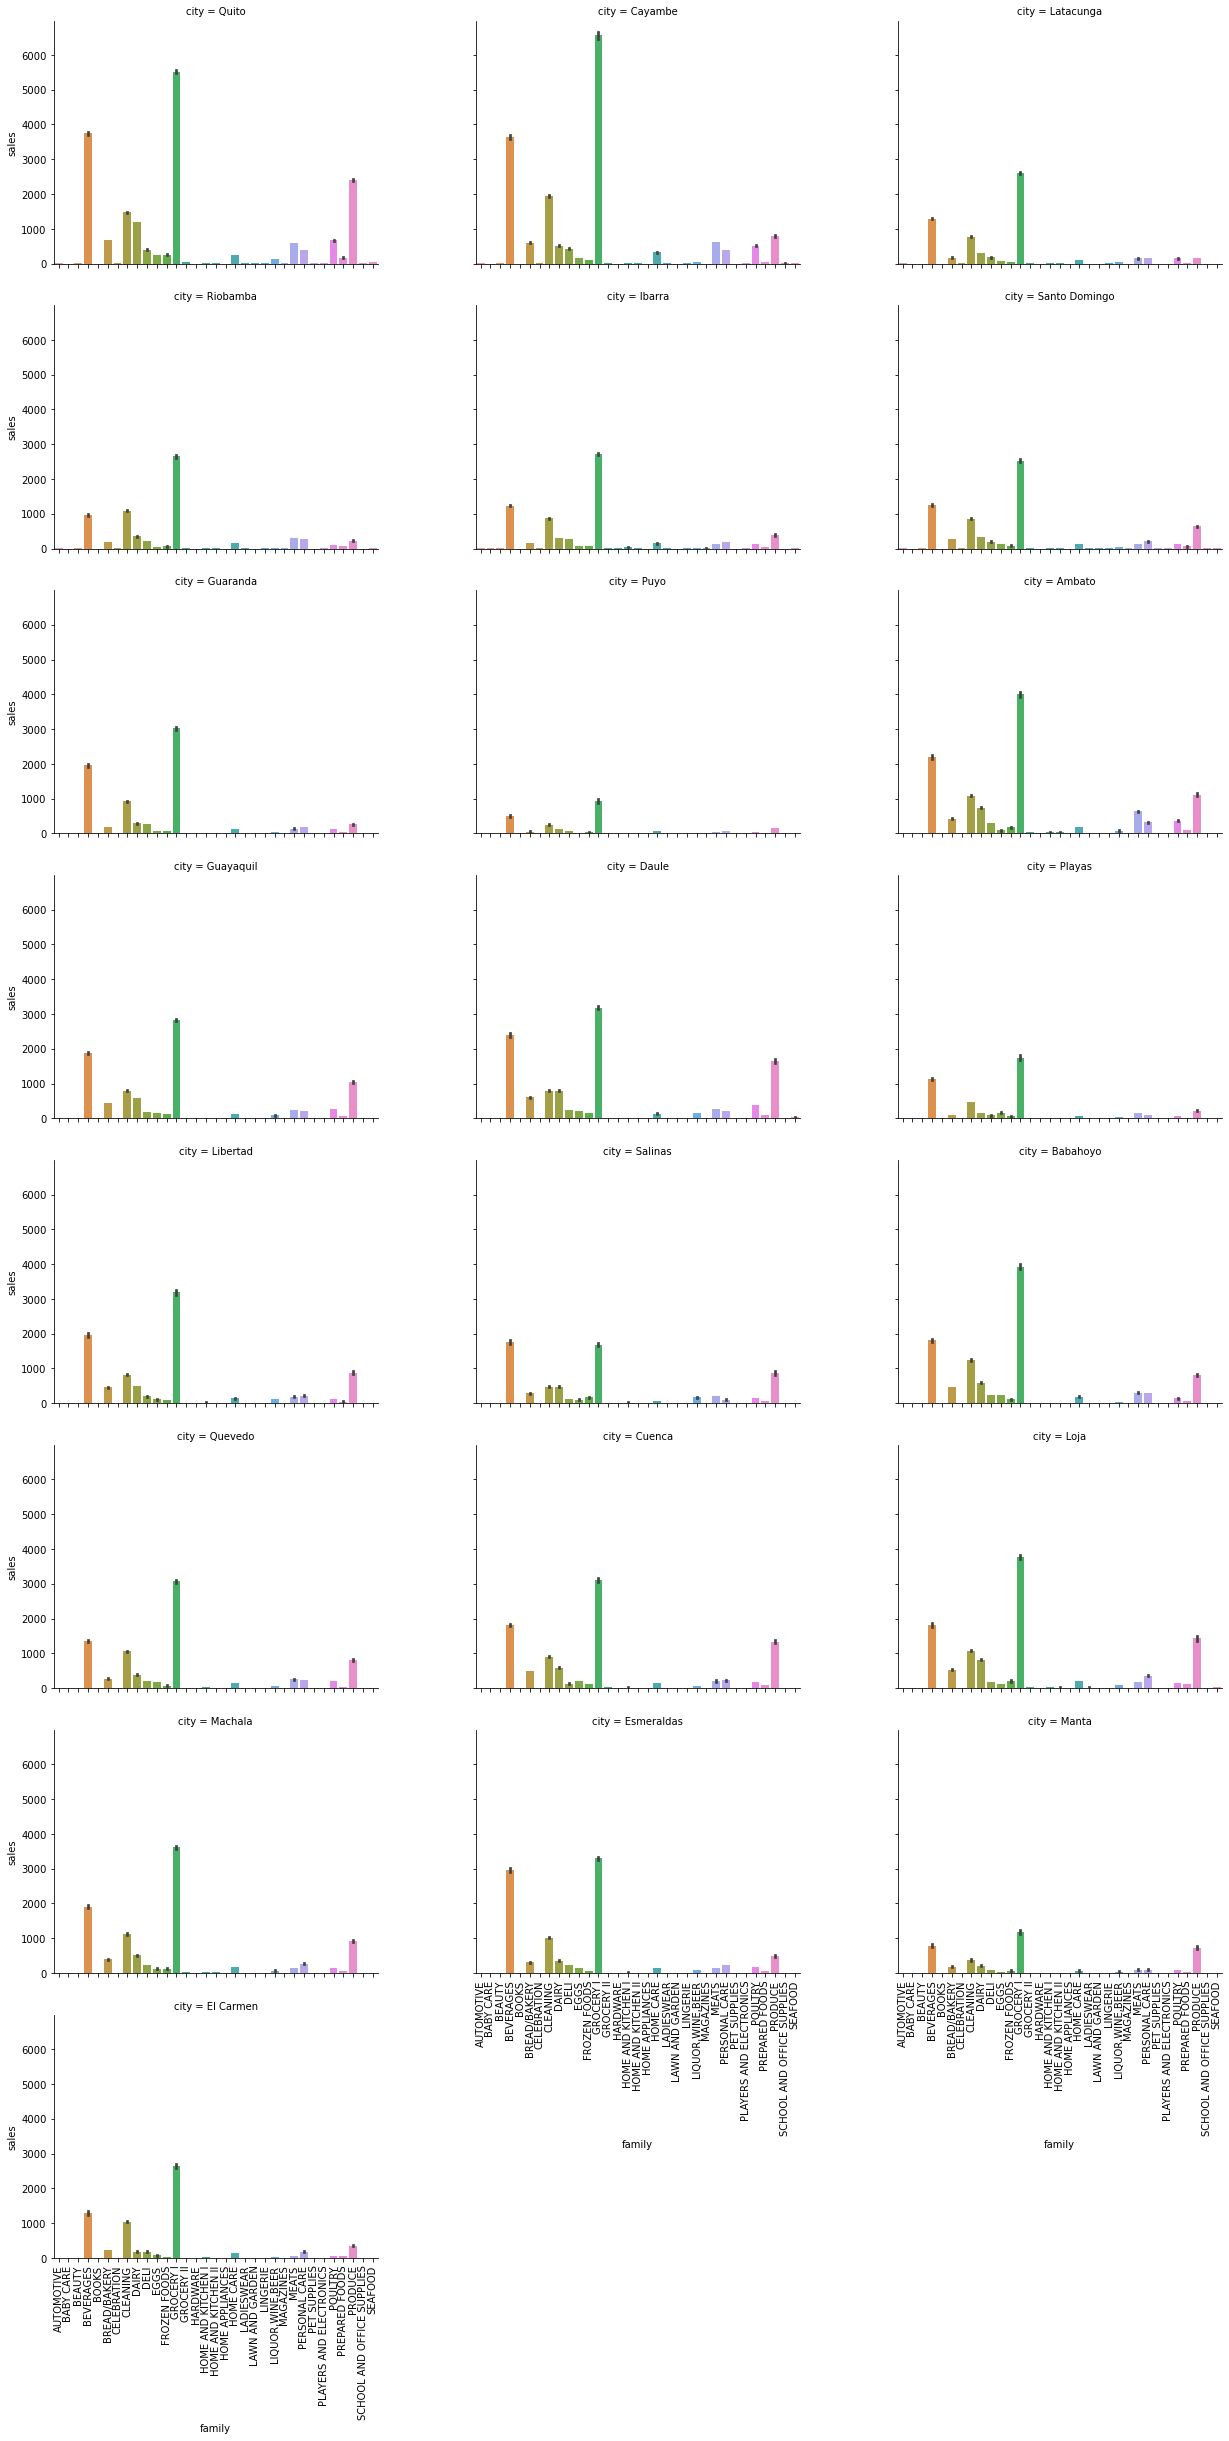

In [21]:
ax = sns.catplot(x="family", y="sales",kind="bar", data=train_store, 
    col='city',
    col_wrap=3, height=4, aspect=1.5, legend=True)
ax.set_xticklabels(rotation = 90)
plt.show()

### 曜日ごとの売上の分析

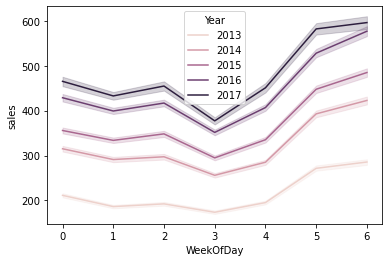

In [22]:
sns.lineplot(x="WeekOfDay",y="sales" , data=train_store, hue="Year")

plt.show()

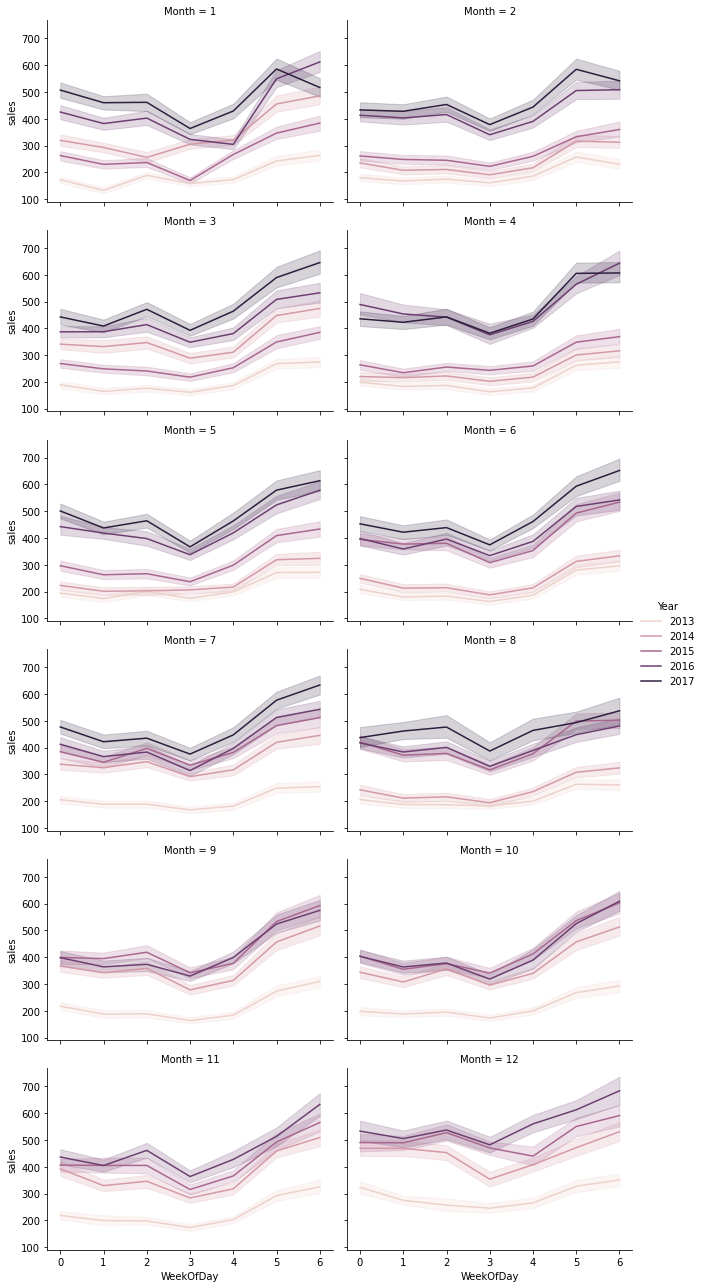

In [23]:
sns.relplot(x="WeekOfDay", y="sales",kind="line", data=train_store, hue="Year",col='Month', #zorder=5,
    col_wrap=2, height=3, aspect=1.5, legend=True)

plt.show()

## カテゴリ変数かどうか50個を境にザックリ検出

In [24]:
ts_unique = train_store.nunique()
for index, value in ts_unique.items():
    print(f"Index : {index}, Value : {value}")
    if value < 50:
        print('*'*50)
        print('keys')
        print('*'*50)
        print(train_store[index].unique())
    else:
        print('*'*50)
        print('skipping', index)
        print('More than 50 unique elements')
        print('*'*50)
        

Index : id, Value : 3000888
**************************************************
skipping id
More than 50 unique elements
**************************************************
Index : store_nbr, Value : 54
**************************************************
skipping store_nbr
More than 50 unique elements
**************************************************
Index : family, Value : 33
**************************************************
keys
**************************************************
['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']
Index : sales, Value : 379610
***********************

# 3. 特徴量分析

### グラフで見てみる。

#### Family、Cluster、Type、State、City、Dateの各要素で一意な値が50未満のもの

In [25]:
import matplotlib.pyplot as plt
import random
def random_color():
    return "#{}{}{}{}{}{}".format(*(random.choice("0123456789abcdef") for _ in range(6)))

# data
ts_sales_type = train_store.groupby('type').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)
ts_sales_family = train_store.groupby('family').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)[:20]
ts_sales_cluster = train_store.groupby('cluster').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False) 
ts_sales_state = train_store.groupby('state').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)
ts_sales_city = train_store.groupby('city').agg({"sales" : "mean"}).reset_index().sort_values(by='sales', ascending=False)


ts_sales_type['color'] = [random_color() for _ in range(len(ts_sales_type))]
ts_sales_type['color'][3:] = [random_color() for _ in range(len(ts_sales_type[3:]))]
ts_sales_family['color'] = [random_color() for _ in range(len(ts_sales_family))]
ts_sales_cluster['color'] = [random_color() for _ in range(len(ts_sales_cluster))]
ts_sales_state['color'] = [random_color() for _ in range(len(ts_sales_state))]
ts_sales_city['color'] = [random_color() for _ in range(len(ts_sales_city))]

fig = make_subplots(rows=5, cols=2, 
                    specs=[[{"type": "bar"}, {"type": "pie"}],
                           [{"colspan": 2}, None],
                           [{"type": "pie"},{"type": "bar"} ],
                           [{"colspan": 2}, None],
                           [{"colspan": 2}, None]],
                    column_widths=[0.5, 0.5], vertical_spacing=0, horizontal_spacing=0.02,
                    subplot_titles=("Average Product Sales", 
                                    "Highest Average Sales in Store Types",
                                    "\n",
                                    "\n"
                                    "Average Sales per State",
                                    "Average Sales per Cluster",
                                    "\n",
                                    "\n"
                                    "Average Sales per City",
                                   ))
fig.add_trace(go.Bar(x=ts_sales_family['sales'], 
                     y=ts_sales_family['family'],
                     marker=dict(color= ts_sales_family['color']),
                     name='Family', orientation='h'), 
                     row=1, col=1)
fig.add_trace(go.Pie(values=ts_sales_type['sales'], labels=ts_sales_type['type'], name='Store Type',
                     marker=dict(colors= ts_sales_family['color']), hole=0.4+(0.1 * random.randrange(-2, 2)),
                     hoverinfo='label+percent+value', textinfo='label'),row=1, col=2)
fig.add_trace(go.Bar(x=ts_sales_cluster['sales'], 
                     y=ts_sales_cluster['cluster'],
                     marker=dict(color= ts_sales_cluster['color']),
                     name='Cluster', orientation='h'), 
                     row=3, col=2)
fig.add_trace(go.Pie(values=ts_sales_state['sales'], labels=ts_sales_state['state'], name='State',
                     marker=dict(colors= ts_sales_state['color']), hole=0.4+(0.1 * random.randrange(-2, 2)),
                     hoverinfo='label+percent+value', textinfo='label'),row=3, col=1)
fig.add_trace(go.Bar(x=ts_sales_city['city'], y=ts_sales_city['sales'], 
                     marker=dict(color= ts_sales_city['color']), name='City'), 
                     row=5, col=1)
fig.update_yaxes(showgrid=False, ticksuffix=' ', categoryorder='total ascending', row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_xaxes(visible=False, row=3, col=2)
fig.update_xaxes(tickmode = 'array', tickvals=ts_sales_cluster.cluster, ticktext=[i for i in range(1,17)], row=3, col=2)
fig.update_yaxes(visible=False, row=5, col=1)
plt_themes = ["plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"]
fig.update_layout(height=1800, bargap=0.3,
                  margin=dict(b=10,r=20,l=20), 
                  xaxis=dict(tickmode='linear'),
                  title_text="Average Sales Analysis",
                  title_x=0.5,
                  template=plt_themes[random.randrange(0, 6)],
                  title_font=dict(size=25, color=random_color(), family="Roboto, sans-serif"),
                  font=dict(color=random_color()),
                  hoverlabel=dict(bgcolor=random_color(), font_size=15, font_family="Roboto, sans-serif"),
                  showlegend=False)
fig.show()

In [26]:
ts_sales_state.iloc[:,:-1].rename(columns={'sales': 'avg_sales'})

,state,avg_sales
12,Pichincha,554.110358
15,Tungurahua,362.632273
8,Loja,339.379530
4,El Oro,300.392253
5,Esmeraldas,294.963151
0,Azuay,294.924279
9,Los Rios,287.243342
6,Guayas,270.172671
1,Bolivar,234.821670
14,Santo Domingo de los Tsachilas,214.942315


In [27]:
ts_sales_city.iloc[:,:-1].rename(columns={'sales': 'avg_sales'})

,city,avg_sales
18,Quito,556.577090
2,Cayambe,509.709179
0,Ambato,362.632273
4,Daule,345.282181
12,Loja,339.379530
1,Babahoyo,319.349181
13,Machala,300.392253
6,Esmeraldas,294.963151
3,Cuenca,294.924279
8,Guayaquil,276.594464


## ECDFと統計グラフをいくつか調べてみよう

Text(0.5, 0, 'Promotions')

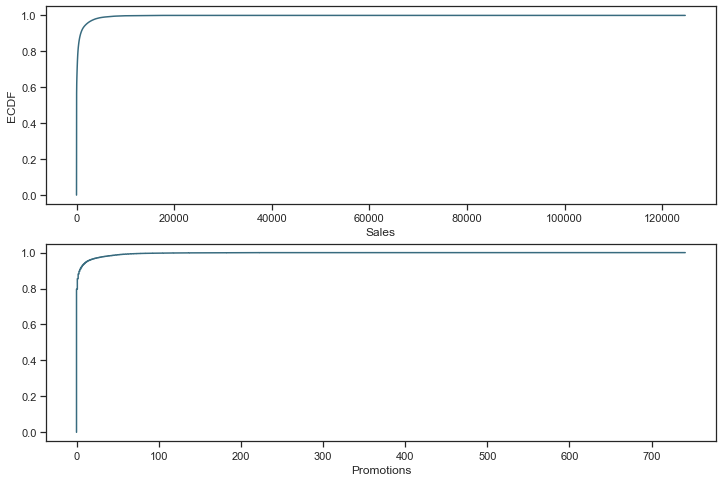

In [28]:
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 8))

plt.subplot(211)
cdf = ECDF(train['sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c)
plt.xlabel('Sales')
plt.ylabel('ECDF')

# plot second ECDF  
plt.subplot(212)
cdf = ECDF(train['onpromotion'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c)
plt.xlabel('Promotions')



In [29]:
store_data.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [30]:
store_data.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

## ストアデータとストアを番号で結合してみよう

In [31]:
print("Joining train set with an additional store information.")

# 内部結合を指定することで、それらのオブザベーションのみを確認することができます。
# 訓練セットと保存セットの両方に存在するものがマージされます。
train_store = pd.merge(train, store_data, how = 'inner', on = 'store_nbr')

print("In total: ", train_store.shape)
train_store.head()

Joining train set with an additional store information.
In total:  (3000888, 17)


,id,store_nbr,family,sales,onpromotion,Year,Month,Day,WeekOfYear,WeekOfDay,Sales_AVG_By_Year,Sales_By_Year_Month,Sales_Year_WeekOfDay,city,state,type,cluster
0,0,1,AUTOMOTIVE,0.0,0,2013,1,1,1,1,216.47953,186.952405,186.236645,Quito,Pichincha,D,13
1,1,1,BABY CARE,0.0,0,2013,1,1,1,1,216.47953,186.952405,186.236645,Quito,Pichincha,D,13
2,2,1,BEAUTY,0.0,0,2013,1,1,1,1,216.47953,186.952405,186.236645,Quito,Pichincha,D,13
3,3,1,BEVERAGES,0.0,0,2013,1,1,1,1,216.47953,186.952405,186.236645,Quito,Pichincha,D,13
4,4,1,BOOKS,0.0,0,2013,1,1,1,1,216.47953,186.952405,186.236645,Quito,Pichincha,D,13


## SalesとFamilyの列を棒グラフでプロットする

<AxesSubplot:xlabel='sales', ylabel='family'>

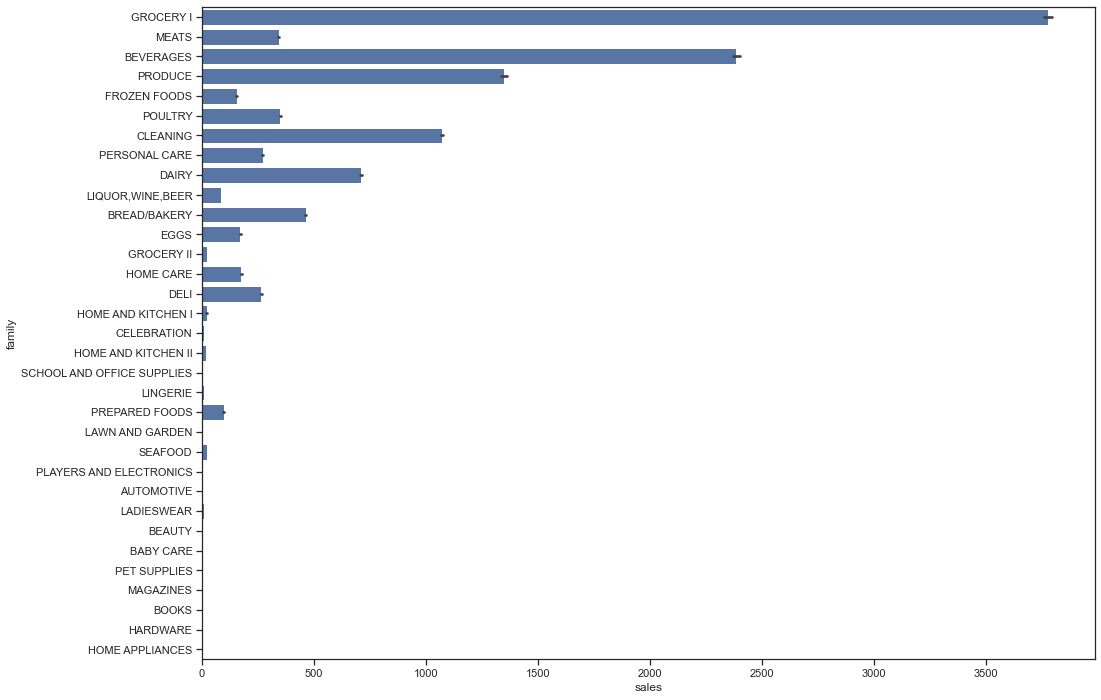

In [32]:
plt.figure(figsize=(16,12))
sns.barplot(x="sales", y="family", data=train_store.sort_values(by=['sales','family'], ascending=False),
            label="Sales", color="b")

## Seaborn Relplotでプロット

<Figure size 1728x1296 with 0 Axes>

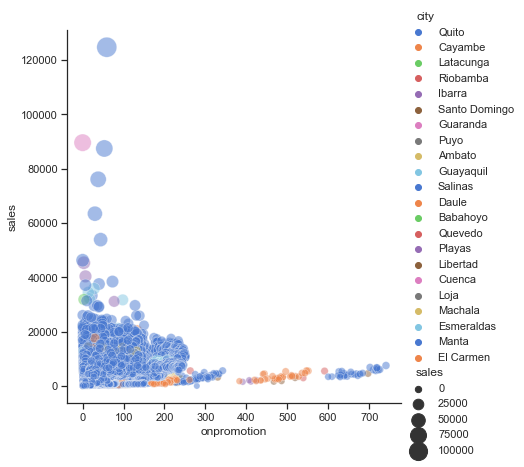

In [33]:
plt.figure(figsize=(24,18))
sns.relplot(x="onpromotion", y="sales", hue="city", size="sales",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=train_store)

## HolidaysをEDA

<AxesSubplot:title={'center':'Counts of type of holiday'}, xlabel='locale', ylabel='count'>

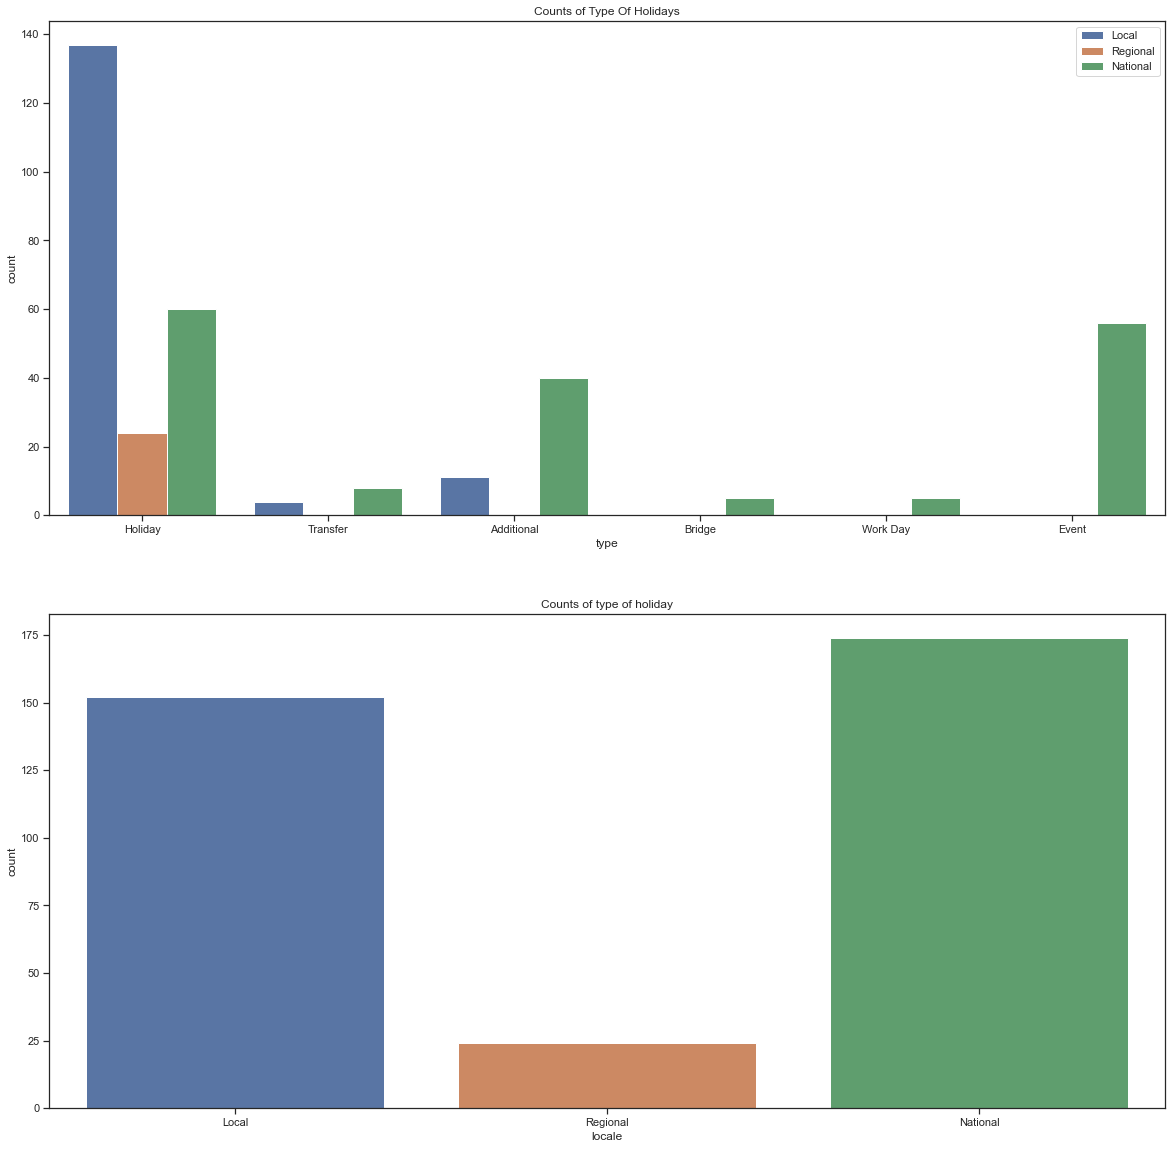

In [34]:
plt.subplots(1,2,figsize=(20,20))
plt.subplot(211)
plt.title('Counts of Type Of Holidays')
sns.countplot(x=holidays_data.type, hue=holidays_data.locale)
plt.legend(loc='upper right')
plt.subplot(212)
plt.title('Counts of type of holiday')
sns.countplot(x=holidays_data.locale)

### 都市名でプロット by a relplot , Sales と Family の関係をhue を State別にプロット

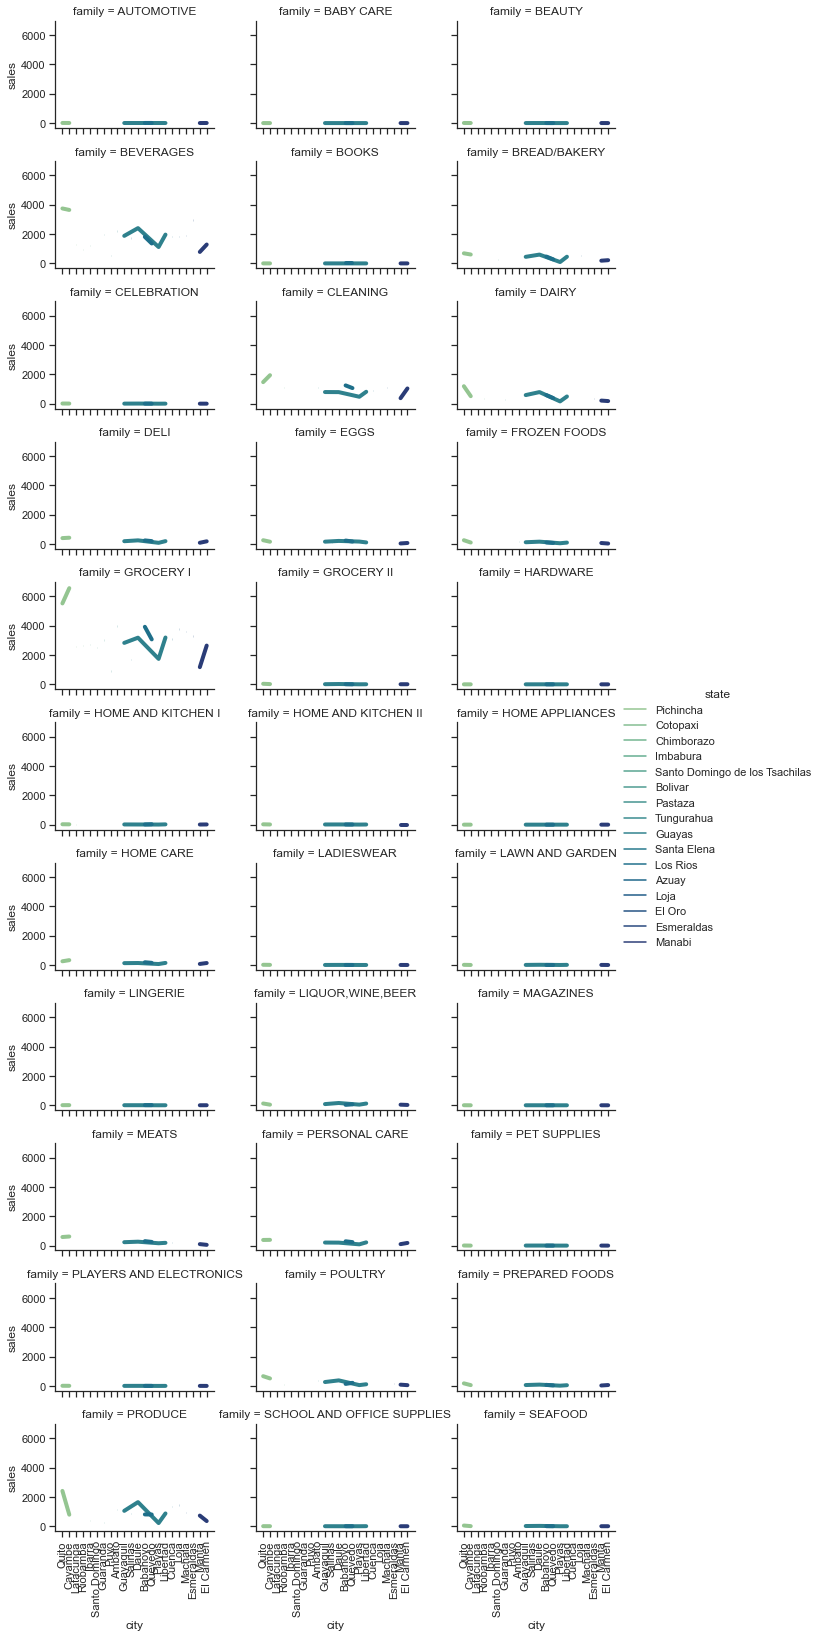

In [37]:
ax=sns.relplot(
    data=train_store,
    x="city", y="sales", col="family", hue="state",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=True,
)
ax.set_xticklabels(rotation = 90)
plt.show()

## Storeデータを EDA

<AxesSubplot:xlabel='count', ylabel='state'>

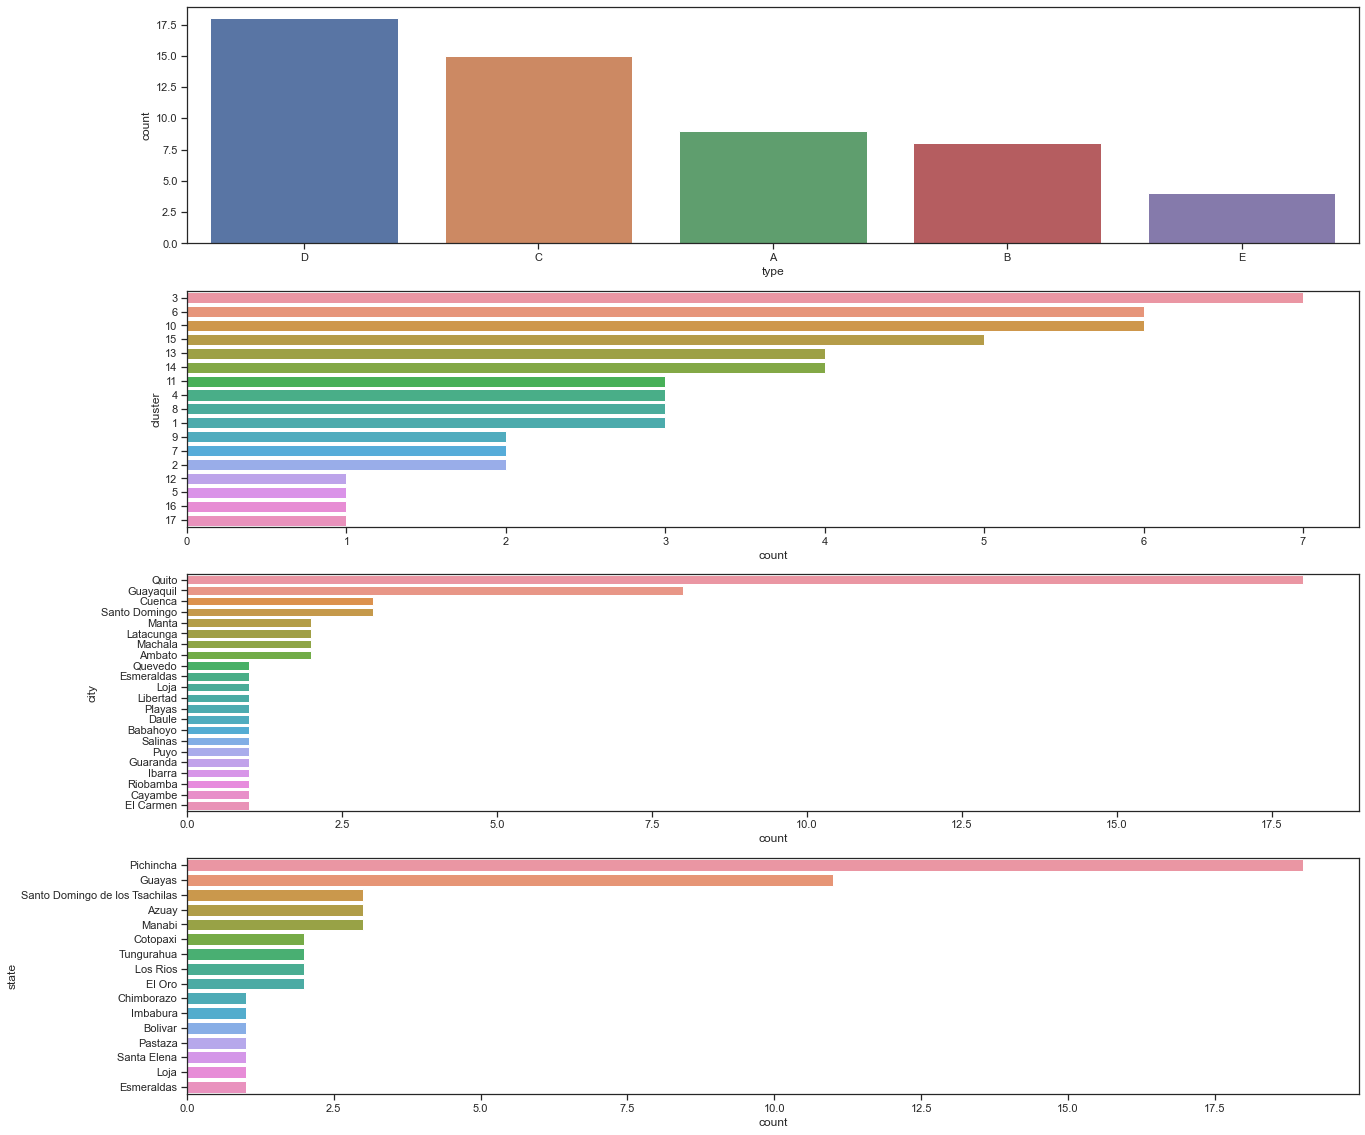

In [38]:
plt.subplots(1,4,figsize=(21,20))
plt.subplot(411)
sns.countplot(x=store_data.type, order = store_data.type.value_counts().index)
plt.subplot(412)
sns.countplot(y=store_data.cluster, order = store_data.cluster.value_counts().index)
plt.subplot(413)
sns.countplot(y=store_data.city, order = store_data.city.value_counts().index)
plt.subplot(414)
sns.countplot(y=store_data.state, order = store_data.state.value_counts().index)

### Plot a Category Plot on Type と Cluster - Kind = Strip Plot

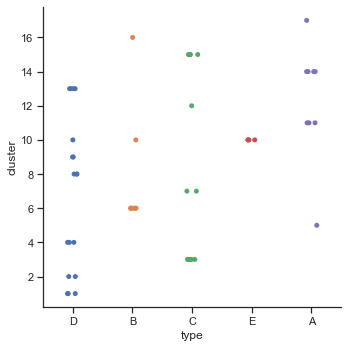

In [39]:
sns.catplot(x = 'type', y='cluster',data=store_data, kind='strip')

### Plot a Category Plot on Type と Cluster - Kind = Swarm Plot

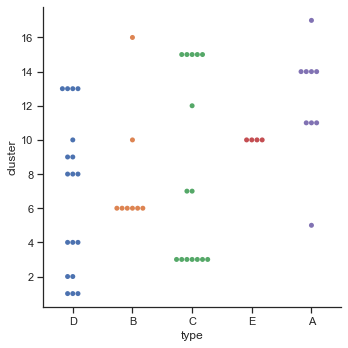

In [40]:
sns.catplot(x = 'type', y='cluster',data=store_data, kind='swarm')

In [41]:
train_store.groupby('state')[['sales']].sum()

,sales
state,
Azuay,4.916860e+07
Bolivar,1.304951e+07
Chimborazo,1.138792e+07
Cotopaxi,2.118226e+07
El Oro,3.338680e+07
Esmeraldas,1.639169e+07
Guayas,1.651544e+08
Imbabura,1.145127e+07
Loja,1.886000e+07


### Plot Barchart on Store Sales by Store と Sales Value

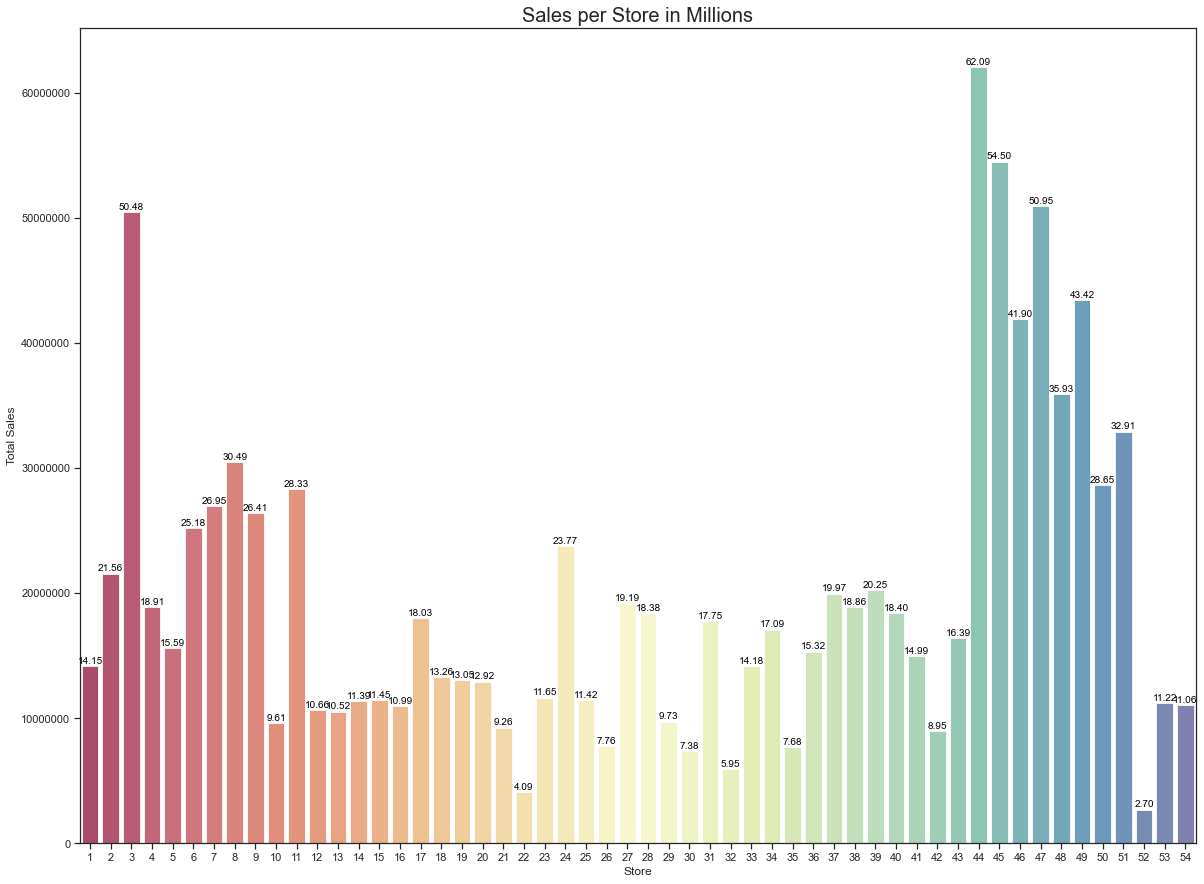

In [42]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
x=train_store.groupby('store_nbr')['city','type','sales'].sum()
x=x.sort_values(by='sales',ascending=False)
x=x.iloc[0:55].reset_index()

plt.figure(figsize=(20,15))
ax= sns.barplot( x.store_nbr ,x.sales, alpha=0.8,  palette="Spectral")
# annotation here
for p in ax.patches:
    ax.annotate("%.2f" % round((p.get_height()/1000000),2), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')


plt.ticklabel_format(style='plain', axis='y')
plt.title("Sales per Store in Millions", fontsize=20)
plt.ylabel('Total Sales', fontsize=12)
plt.xlabel('Store', fontsize=12)
plt.show()


### Plot Barchart on Store Sales by City and Sales Value

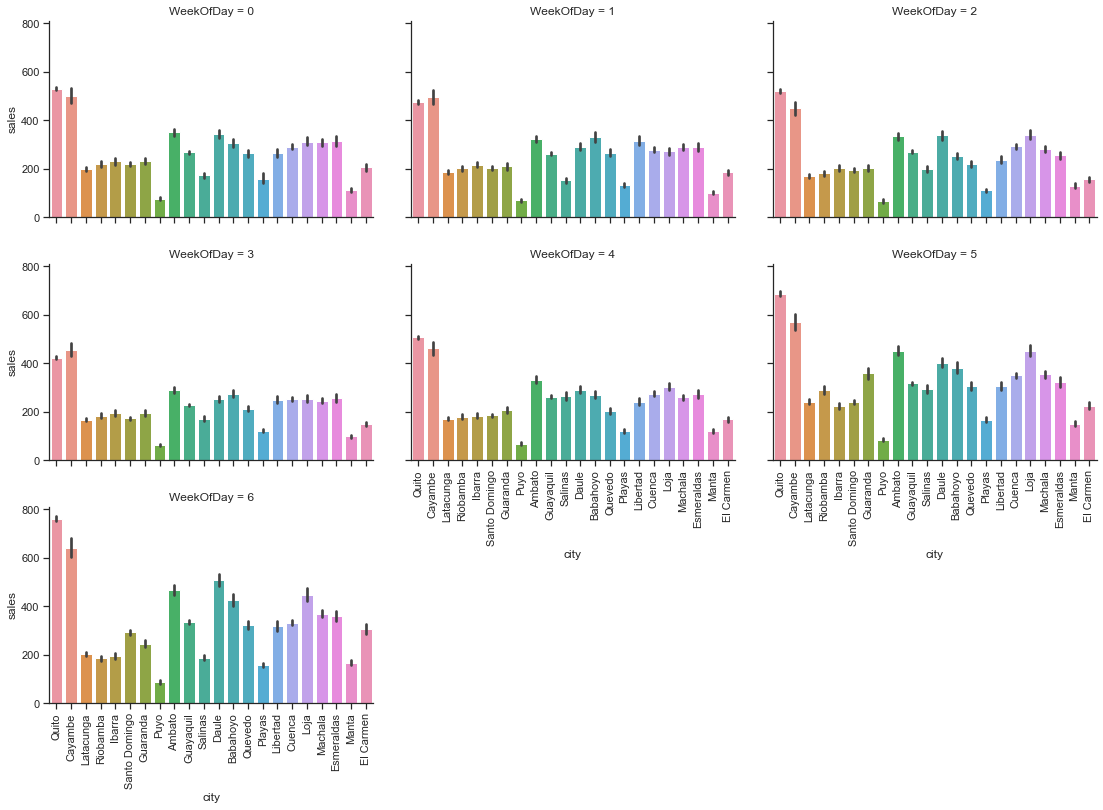

In [43]:
ax = sns.catplot(x="city", y="sales",kind="bar", data=train_store, 
    col='WeekOfDay',
    col_wrap=3, height=3.5, aspect=1.5, legend=True)
ax.set_xticklabels(rotation = 90)
plt.show()

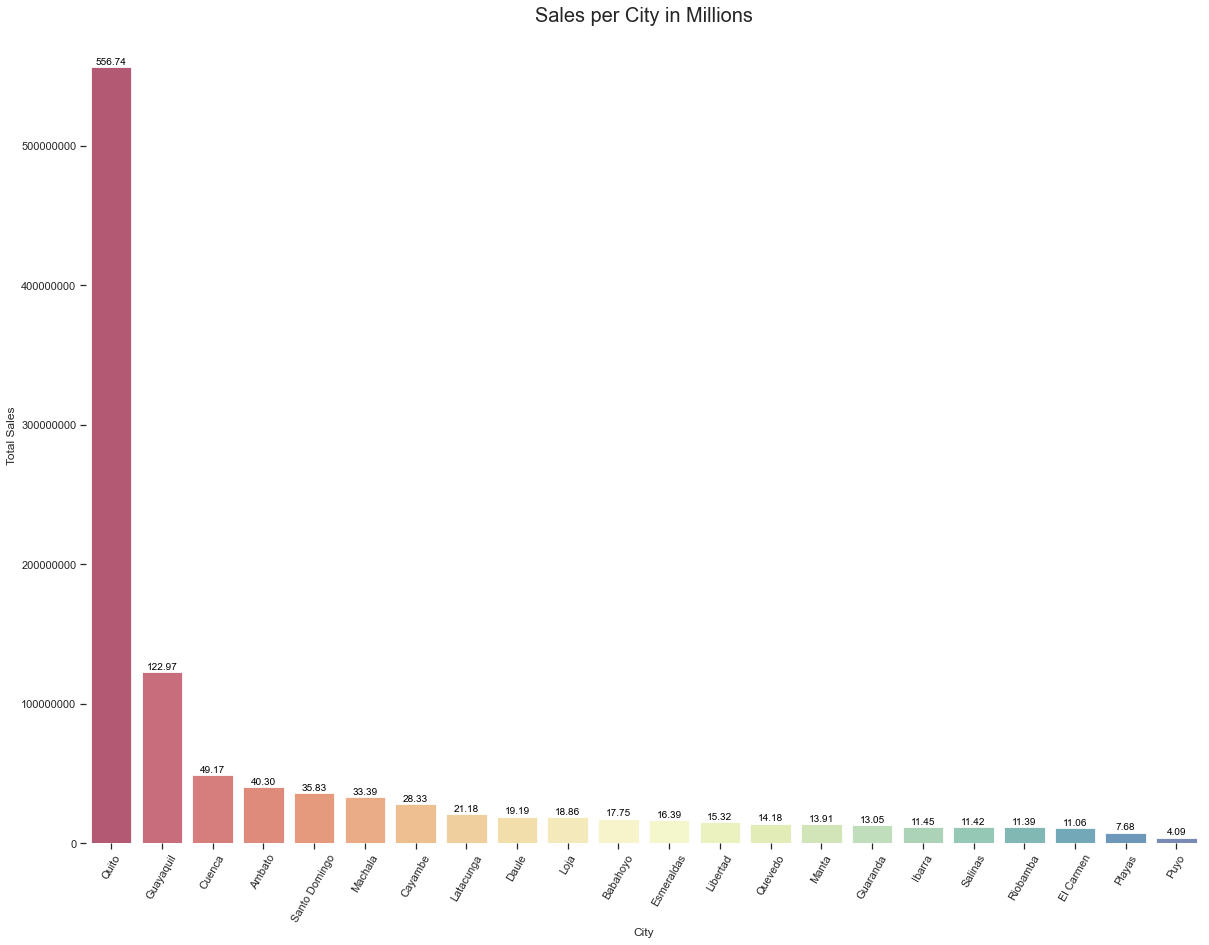

In [44]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
x=train_store.groupby('city')['store_nbr','type','sales'].sum()
x=x.sort_values(by='sales',ascending=False)
x=x.iloc[0:55].reset_index()

plt.figure(figsize=(20,15))
ax= sns.barplot( x.city ,x.sales, alpha=0.8,  palette="Spectral")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
# annotation here
for p in ax.patches:
    ax.annotate("%.2f" % round((p.get_height()/1000000),2), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')


plt.ticklabel_format(style='plain', axis='y')
plt.title("Sales per City in Millions", fontsize=20)
plt.ylabel('Total Sales', fontsize=12)
plt.xlabel('City', fontsize=12)
loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=60)
sns.despine(left=True, bottom=True)
plt.show()


### Plot Barchart on Store Sales by State and Sales Value

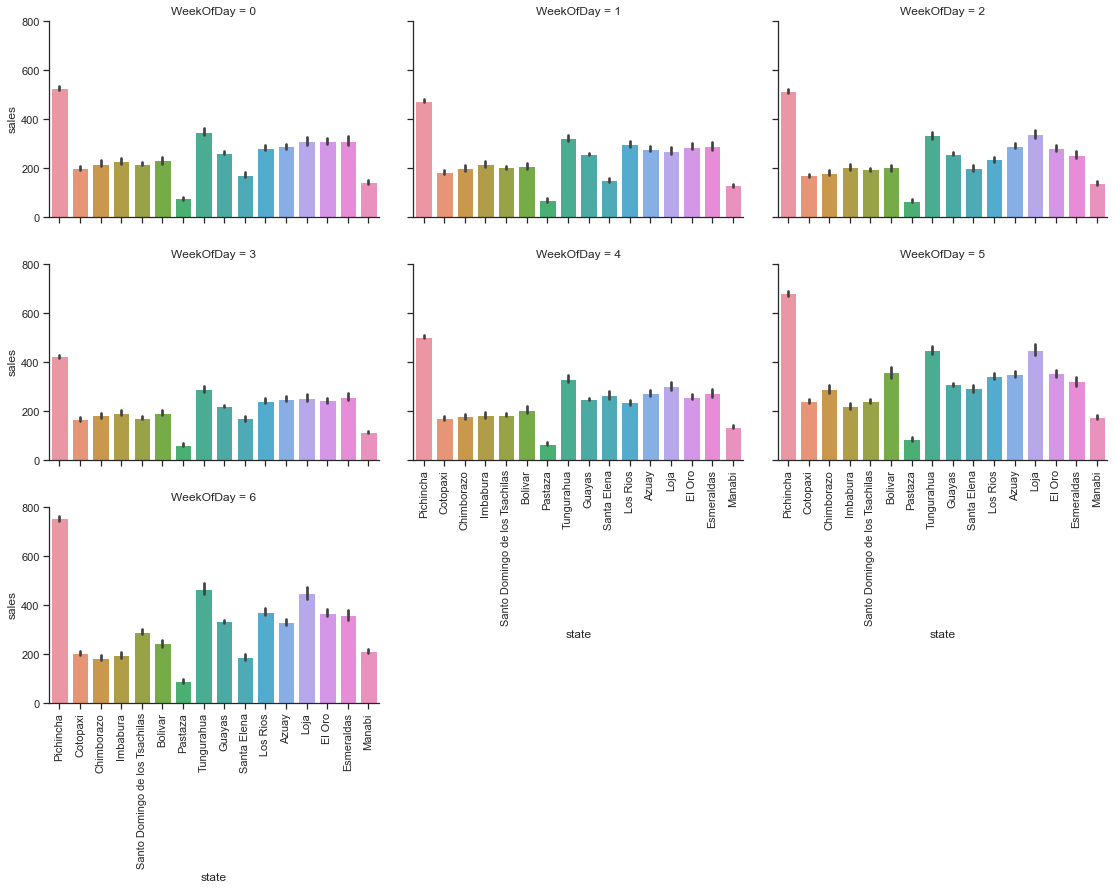

In [45]:
ax = sns.catplot(x="state", y="sales",kind="bar", data=train_store, 
    col='WeekOfDay',
    col_wrap=3, height=3.5, aspect=1.5, legend=True)
ax.set_xticklabels(rotation = 90)
plt.show()

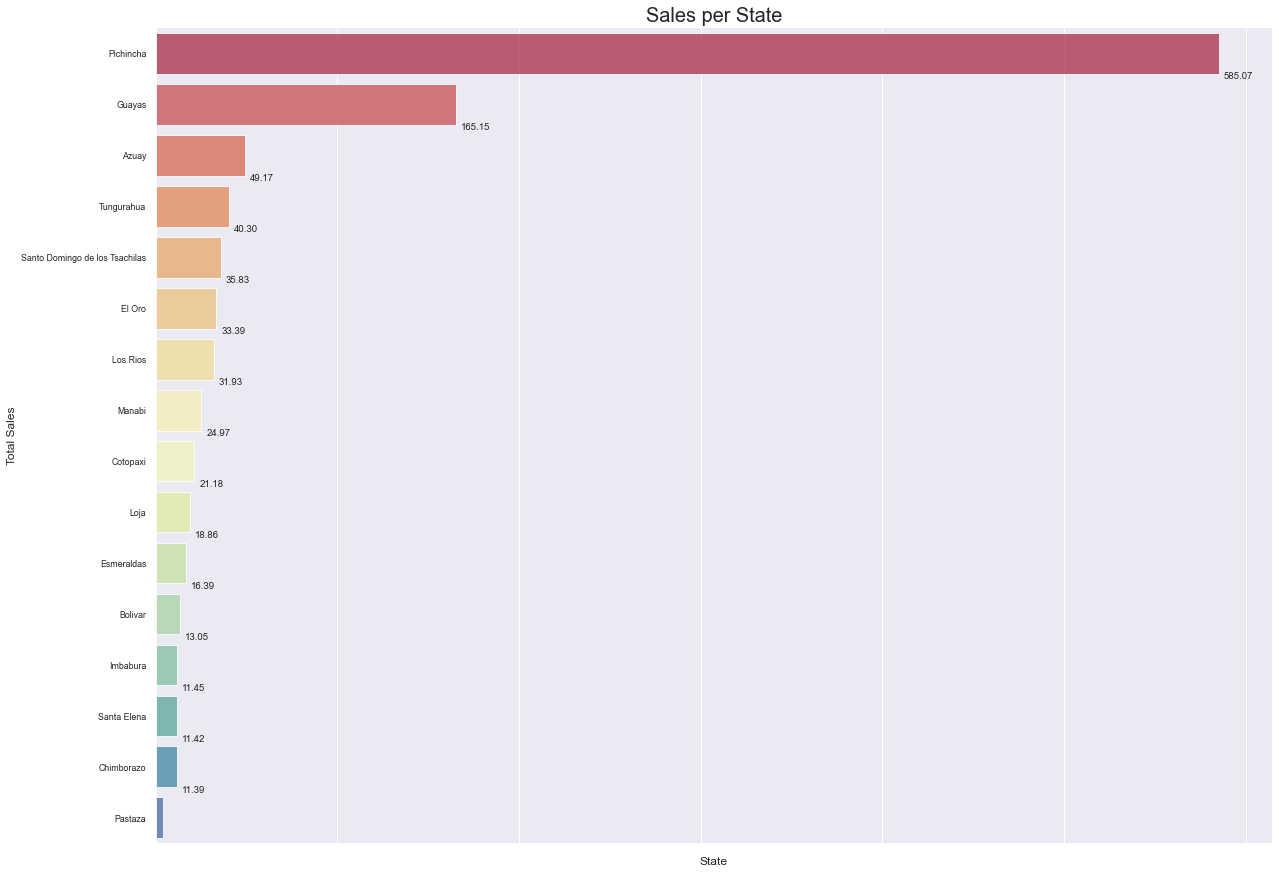

In [46]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
sns.set(font_scale=0.8)
x=train_store.groupby('state')['store_nbr','type','sales'].sum()
x=x.sort_values(by='sales',ascending=False)
x=x.iloc[0:55].reset_index()

plt.figure(figsize=(20,15))
ax= sns.barplot( x.sales ,x.state, alpha=0.8,  palette="Spectral")

for p in ax.patches:
    ax.annotate("%.2f" % round((p.get_width()/1000000),2), (p.get_x() + p.get_width(), p.get_y() + 1.2),
                xytext=(5, 15), textcoords='offset points')

sns.set(font_scale=0.8)
plt.title("Sales per State", fontsize=20)
plt.ylabel('Total Sales', fontsize=12)
plt.xlabel('State', fontsize=12)
loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=60)
sns.despine(left=True, bottom=True)
sns.set_style('whitegrid')
plt.show()